In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import models, transforms, datasets

import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import time
import os
import copy


# hyper parameters
num_epochs = 5
num_classes = 2
batch_size = 8
learning_rate = 0.001
model_name = "resnet"

In [3]:
import PIL.Image as Image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])


In [4]:
# get dataset

train_dataset = datasets.CelebA(root='./data',
                                split='train',
                                target_type='attr',
                                transform=transform,
                                download=False)
val_dataset = datasets.CelebA(root='./data',
                                split='valid',
                                target_type='attr',
                                transform=transform,
                                download=False)
test_dataset = datasets.CelebA(root='./data',
                                split='test',
                                target_type='attr',
                                transform=transform,
                                download=False)

# data loader
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                            batch_size=batch_size,
                            shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=False)


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
"""unzip the dataset"""
# import zipfile
#
# with zipfile.ZipFile("img_align_celeba.zip","r") as zip_ref:
#     zip_ref.extractall("data/")

'unzip the dataset'

In [7]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
    if renorm:
        img = img/2 + 0.5
    img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
    plt.figure()
    plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
    plt.axis('off')
    plt.show()

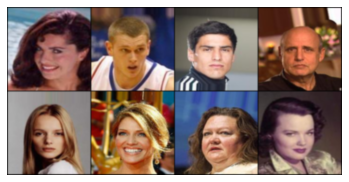

In [8]:
"""Visualize a few images"""
batch, classes = next(iter(train_loader))
show(batch, renorm = True, nrow=4)

In [9]:
batch.shape

torch.Size([8, 3, 224, 224])

In [10]:
classes.shape

torch.Size([8, 40])

In [27]:
model = models.resnet18(pretrained=True)
# freeze all params in the layers except for the final fc
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
for name, params in model.named_parameters():
      print(name, params.size())

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [29]:
train_step = len(train_loader) # total number of `i`

for epoch in range(num_epochs): # repeat the entire training `num_epochs` times
    # for each training sample
    for i, (images, labels) in enumerate(train_loader):
        # move to gpu if available
        labels = labels[:, 2]
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) # still a tensor so we need to use .item() when printing
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print
        if (i+1) % 100 == 0:
            print('Epoch: [{}/{}], Step[{}/{}], Loss:{:.4f}' \
                  .format(epoch+1, num_epochs, i+1, train_step, loss.item()))

Epoch: [1/5], Step[100/20347], Loss:0.2680
Epoch: [1/5], Step[200/20347], Loss:1.5216
Epoch: [1/5], Step[300/20347], Loss:0.2503
Epoch: [1/5], Step[400/20347], Loss:0.3120
Epoch: [1/5], Step[500/20347], Loss:0.7006
Epoch: [1/5], Step[600/20347], Loss:0.5392
Epoch: [1/5], Step[700/20347], Loss:0.1679
Epoch: [1/5], Step[800/20347], Loss:0.5467
Epoch: [1/5], Step[900/20347], Loss:1.3337
Epoch: [1/5], Step[1000/20347], Loss:0.4003
Epoch: [1/5], Step[1100/20347], Loss:0.6812
Epoch: [1/5], Step[1200/20347], Loss:0.5437
Epoch: [1/5], Step[1300/20347], Loss:0.2967
Epoch: [1/5], Step[1400/20347], Loss:0.4863
Epoch: [1/5], Step[1500/20347], Loss:0.5016
Epoch: [1/5], Step[1600/20347], Loss:0.3853
Epoch: [1/5], Step[1700/20347], Loss:0.2982
Epoch: [1/5], Step[1800/20347], Loss:0.3324
Epoch: [1/5], Step[1900/20347], Loss:0.8072
Epoch: [1/5], Step[2000/20347], Loss:0.5152
Epoch: [1/5], Step[2100/20347], Loss:0.5417
Epoch: [1/5], Step[2200/20347], Loss:0.8630
Epoch: [1/5], Step[2300/20347], Loss:0.48

In [30]:
# save model
torch.save(model.state_dict(), 'cnn.ckpt')

# load
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [32]:
model.eval() # BatchNorm uses moving mean/variance instead of mini-batch mean/variance

with torch.no_grad():
    # initialize the stats
    correct = 0
    total = 0
    # pass through testing data once
    for images, labels in val_loader:

        labels = labels[:, 2]
        # again move to device first
        images = images.to(device)
        labels = labels.to(device)
        # forward once
        outputs = model(images)
        # instead of calculating loss we will get predictions
        # it's essetially outputs just reformatting imo
        _, predicted = torch.max(outputs.data, 1)
        # accumulate stats
        total += labels.size(0) # yeah again, number of elements in the tensor
        correct += (labels == predicted).sum().item()

    # print
    print('Test accuracy on 10000 test images: {}%' \
            .format(100 * correct / total))

Test accuracy on 10000 test images: 63.19507063420499%
